## Introduction

In this notebook, we will be using a pre-processed version of our loan dataset to model Loss-Given-Default (LGD) and Exposure-at-Default (EAD).
- LGD is the percentage of an exposure that cannot be recoved after default.
- EAD is the outstanding loan amount when the borrower has defaulted.


Note: see pre-processing steps in PD modelling notebook.

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We import the protfolio data pre-processed during our PD modeling exercise. This 

In [133]:
df_loans = pd.read_csv('loans_preprocessed.csv')

<br>

#### Subsetting Data to Written-off Loans

LGD is generally calculated with the equation:

$$LGD = (1- Recovery Rate)*100%$$
Where:
- Recovery rate is the percentage of the loan recoved 

Because we need to observe the Recovery Rate, we need to observe only defaulted loans which had sometime for repayment after default. Hence, we will be working with a dataframe containing only written-off loans.

In [134]:
df_loans.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

We create a new dataframe comprised only of written-off loans.

In [135]:
df_defaulted = df_loans[df_loans.loan_status.isin(['Charged Off', 
                                   'Does not meet the credit policy. Status:Charged Off'])]
df_defaulted.shape

(43236, 80)

As we previously mentioned, LGD is given by:
$$LGD = (1- Recovery\ Rate)*100%$$

- Recovery Rate (RR) is $RR = \frac {Recovery\ Amount} {EAD}$.
<br>

- EAD is usually calculated as the remaining exposure when the loan has defaulted. We can see from the table below that it can be calculated by subtracting the total recovered principal ('total_rec_prncp') from the funded amount ('funded_amnt').

In [136]:
# Show all columns
pd.options.display.max_columns = None

# Columns to infer EAD calculation
amounts_columns = ['funded_amnt','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'recoveries', 'grade']
df_defaulted.loc[:, amounts_columns].head(3)

,funded_amnt,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,grade
1,2500,1008.71,1008.71,456.46,117.08,C
8,5600,646.02,646.02,162.02,189.06,F
9,5375,1476.19,1469.34,673.48,269.29,B


In [137]:
# Calculating EAD
df_defaulted.loc[:,'EAD'] = df_defaulted['funded_amnt'] - df_defaulted['total_rec_prncp']

# Calculating Recovery Rate
df_defaulted.loc[:, 'RR'] = df_defaulted['recoveries'] / df_defaulted['EAD']

/tmp/ipykernel_584424/2835024230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defaulted.loc[:,'EAD'] = df_defaulted['funded_amnt'] - df_defaulted['total_rec_prncp']
/tmp/ipykernel_584424/2835024230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defaulted.loc[:, 'RR'] = df_defaulted['recoveries'] / df_defaulted['EAD']


Let us ensure that the values of EAD and RR are logical for all observations.

In [138]:
df_defaulted['EAD'].describe().round()

count    43236.0
mean     10904.0
std       7474.0
min          2.0
25%       4943.0
50%       9224.0
75%      15371.0
max      35000.0
Name: EAD, dtype: float64

In [139]:
df_defaulted['RR'].describe().round(2)

count    43236.00
mean         0.08
std          0.12
min          0.00
25%          0.00
50%          0.05
75%          0.14
max          1.59
Name: RR, dtype: float64

The recovery rate for some loans is above 1 which is illogical. This may sometimes occur due to accounting error of not splitting recovered amounts into fees, interest, and principal. We will impute such cases to have a maximum of one.

In [140]:
# Impute RR values that are above 1 to a value of 1
df_defaulted.loc[df_defaulted.RR > 1, 'RR'] = 0.99

# Just in case for future data, we wmpute RR values that are below 0 to a minimum of 0
df_defaulted.loc[df_defaulted.RR < 0, 'RR'] = 0

<br>

## LGD Modelling

### Exploring the Dependent Varaible LGD

We examine the distribution of our target variables in order to decide **which distribution fit the data best.**

(-0.25, 1.0)

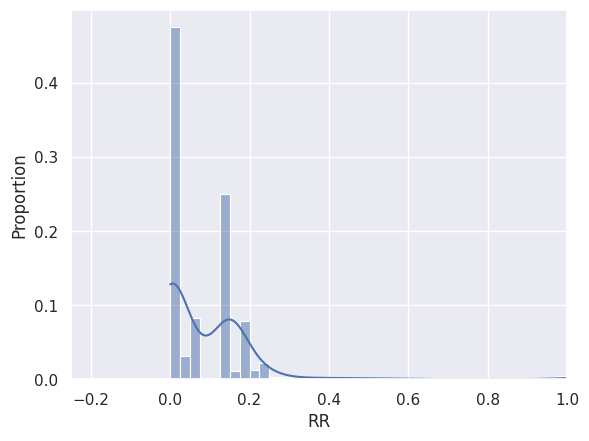

In [141]:
sns.histplot(data = df_defaulted, x = 'RR', bins = 40, stat = 'proportion', kde = True, kde_kws={'bw_adjust': 3})
plt.xlim(-0.25,1)

Since 50% of observations have a Recovery Rate of zero, we will opt to a two-stage modelling approach:
- **Stage 1:** Model whether the RR is 0 or not. For this we can use a logistic regression model.
- **Stage 2:** If RR > 0, we can model its expected value with linear regression.

### Stage 1: Logistic Regression

For the first stage, we need to establish a dependent variable showing whether the Recovery Rate (RR) will be zero or not.

In [142]:
# Create a dummy for a Zero or non-Zero RR
df_defaulted.loc[:, 'Zero_RR'] = np.where(df_defaulted.RR < 0.001, 0, 1)

/tmp/ipykernel_584424/134948401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defaulted.loc[:, 'Zero_RR'] = np.where(df_defaulted.RR < 0.001, 0, 1)


We also need to focus on the most relevant variables which are usually determined through explanation. Some of the key variables usually relied upon as predictors are missing in this dataset such as Collateral value, Loan-to-value (LTV) ratio, Industry sector, Economic conditions. Still we rely on other variables that are relevant to LGD modelling such as Grade, Home_Ownership, Loan Purpose, Employment Length, Loan Term ..etc.

In [143]:
# Create a new variable containing the number of months between last_payment_date and end of 2016

# Convert to datetime (the given year is two-digit and needs "20" prefix)
df_defaulted['prop_last_pymnt_d'] = pd.to_datetime(df_defaulted['last_pymnt_d'], format='%b-%y')

# Reference date is end of 2016
ref_date = pd.to_datetime('2016-12-31')

# Calculating the difference between ref-date and last payment date in months
df_defaulted['last_payment_months'] = (ref_date.year - df_defaulted['prop_last_pymnt_d'].dt.year) * 12 + (ref_date.month - df_defaulted['prop_last_pymnt_d'].dt.month)

# We delete records with na values in order not to distord our model
df_defaulted = df_defaulted.dropna(subset=['last_payment_months'])

/tmp/ipykernel_584424/773965960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defaulted['prop_last_pymnt_d'] = pd.to_datetime(df_defaulted['last_pymnt_d'], format='%b-%y')
/tmp/ipykernel_584424/773965960.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defaulted['last_payment_months'] = (ref_date.year - df_defaulted['prop_last_pymnt_d'].dt.year) * 12 + (ref_date.month - df_defaulted['prop_last_pymnt_d'].dt.month)


In [144]:
home_own_dummies.columns

Index(['Home_Own: _NONE', 'Home_Own: _OTHER', 'Home_Own: _OWN',
       'Home_Own: _RENT'],
      dtype='object')

In [145]:
grade_dummies = pd.get_dummies(df_defaulted.grade, drop_first = True, prefix = 'Grade: ')
home_own_dummies = pd.get_dummies(df_defaulted.home_ownership, drop_first = True, prefix = 'Home_Own: ')
verif_dummies = pd.get_dummies(df_defaulted.verification_status, drop_first = True, prefix = 'Verif_Status: ')

X = df_defaulted[['dti','funded_amnt', 'emp_length_int', 'term_int', 'last_payment_months',
                  'mths_since_issue_d', 'mths_since_earliest_cr_line', 'mths_since_last_delinq', 'mths_since_last_record']]
X = pd.concat([X, grade_dummies, home_own_dummies, verif_dummies], axis = 1)
y = df_defaulted[['Zero_RR', 'RR']]

y.head()

,Zero_RR,RR
1,1,0.057293
8,1,0.034767
9,1,0.057277
12,1,0.057374
14,1,0.141267


We now need to split our new dataset into training and test sets. 

In [146]:
from sklearn.model_selection import train_test_split


# Split data into training and test set
X_train_RR, X_test_RR, y_train_RR, y_test_RR = train_test_split(X, y, train_size = 0.8, random_state = 1)


# Adding constants to X_train_RR and X_test_RR
X_train_RR.insert(0, 'intercept', 1)
X_test_RR.insert(0, 'intercept', 1)

print(X_train_RR.shape)
print(X_test_RR.shape)
print(y_train_RR.shape)
print(y_test_RR.shape)

(34288, 22)
(8572, 22)
(34288, 2)
(8572, 2)


<br>

#### Fitting Logistic Regression Model

We now fit a logistic regression model to determine which observations should be assigned a RR of zero and which should not.

In [147]:
import statsmodels.api as sm

RR_model = sm.Logit(y_train_RR.Zero_RR, X_train_RR.astype(float)).fit()
RR_model.summary()

         Current function value: 0.647185
         Iterations: 35


/home/mohammad/Desktop/Practice/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Zero_RR   No. Observations:                34288
Model:                          Logit   Df Residuals:                    34266
Method:                           MLE   Df Model:                           21
Date:                Fri, 04 Apr 2025   Pseudo R-squ.:                 0.05929
Time:                        02:57:21   Log-Likelihood:                -22191.
converged:                      False   LL-Null:                       -23589.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                         -1.4229      0.096    -14.799      0.000      -1.611      -1.234
dti                               -0.0146      0.002     -9.658      0.000      -0.018      -0.012
funded_amnt                     8.817e-06   1.64e-06      5.366      0.000     5.6e-06     1.2e-05
emp_length_int                    -0.0007      0.003     -0.238      0.812      -0.007       0.005
term_int                          -0.0021      0.001     -1.689      0.091      -0.005       0.000
last_payment_months                0.0213      0.002     13.802      0.000       0.018       0.024
mths_since_issue_d                 0.0192      0.001     13.680      0.000       0.016       0.022
mths_since_earliest_cr_line       -0.0009      0.000     -6.568      0.000      -0.001      -0.001
mths_since_last_delinq             0.0007      0.001      1.396      0.163      -0.000       0.002
mths_since_last_record            -0.0033      0.000     -8.120      0.000      -0.004      -0.003
Grade: _B                          0.1363      0.053      2.571      0.010       0.032       0.240
Grade: _C                          0.1949      0.053      3.705      0.000       0.092       0.298
Grade: _D                          0.3203      0.054      5.901      0.000       0.214       0.427
Grade: _E                          0.3728      0.060      6.219      0.000       0.255       0.490
Grade: _F                          0.5523      0.070      7.887      0.000       0.415       0.690
Grade: _G                          0.3847      0.101      3.815      0.000       0.187       0.582
Home_Own: _NONE                   12.2892    257.635      0.048      0.962    -492.665     517.244
Home_Own: _OTHER                  -0.7552      0.412     -1.832      0.067      -1.563       0.053
Home_Own: _OWN                     0.0997      0.042      2.372      0.018       0.017       0.182
Home_Own: _RENT                    0.0596      0.025      2.393      0.017       0.011       0.108
Verif_Status: _Source Verified     0.0336      0.032      1.052      0.293      -0.029       0.096
Verif_Status: _Verified            0.1792      0.031      5.825      0.000       0.119       0.240
==================================================================================================
"""

In [148]:
y_pred_prob = RR_model.predict(X_test_RR.astype(float))  # Probabilities (between 0 and 1)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_RR.Zero_RR, y_pred_class)
print(conf_matrix)


[[2160 1617]
 [1284 3511]]


We have chosen a cut-off rate of 0.4 because this will increase the proportion of RR classified as non-zero. This way we can still estimate them as close to zero during the second stage of our modelling. Below we see that we get a Sensitivity (true positive rate) of 54% and an Accuracy of 61%.

In [149]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_RR.Zero_RR, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

tpr = conf_matrix[1,1] / sum(conf_matrix).sum()
print(f"Sensitivity: {tpr:.4f}")

Accuracy: 0.6616
Sensitivity: 0.4096


The Area under the ROC curve (AUC) is around 0.70 which is satisfactory for a two staged approach.

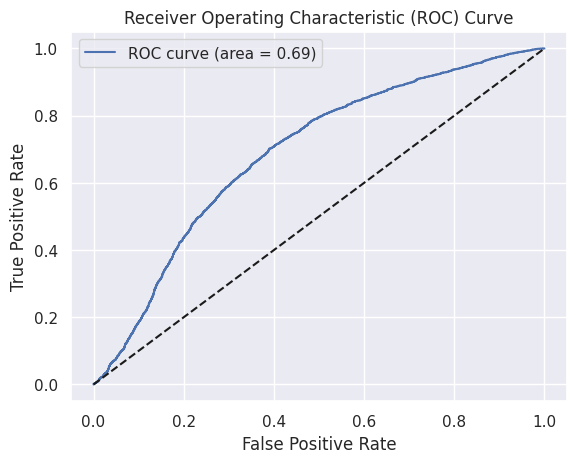

In [150]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_RR.Zero_RR, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


<br>

#### Saving the model

We will use the module ***pickle*** to save our model parameters. Pickle will allow us to reimport our model later (including the estimated coefficients) and use it for prediction.

In [151]:
import pickle

with open('RR_model.pkl', 'wb') as f:
    pickle.dump(RR_model, f)

<br>

### Stage 2: Linear Regression for non-zero RR

The second stage of LGD modelling is fitting a linear regression model to infer non-zero values of Recovery Rates (RR).

We need to filter our training and testing data data to only observations with non-zero RR rate.

In [152]:
# Filtering training sets to non-zero RR-values
X_train_2 = X_train_RR[y_train_RR.Zero_RR == 1]
y_train_2 = y_train_RR.RR[y_train_RR.Zero_RR == 1]

X_test_2 = X_test_RR[y_test_RR.Zero_RR == 1]
y_test_2 = y_test_RR.RR[y_test_RR.Zero_RR == 1]


print(X_train_2.shape)
print(X_test_2.shape)
print(y_train_2.shape)
print(y_test_2.shape)


(18886, 22)
(4795, 22)
(18886,)
(4795,)


When we fit the linear regression model, we can see that we have an Adjusted R-Squared value of around 0.26 which means that the model is not strong at explaining the variation in RR. Most of the used variabels are statistically significant but with weak strength in explaining the variation in RR. This is mainly due to the absence of strong predictors mentioned at the beginning of the section.

In [153]:
RR_model2 = sm.OLS(y_train_2, X_train_2.astype(float)).fit()
RR_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RR   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     24.39
Date:                Fri, 04 Apr 2025   Prob (F-statistic):           9.96e-94
Time:                        02:57:21   Log-Likelihood:                 13850.
No. Observations:               18886   AIC:                        -2.766e+04
Df Residuals:                   18864   BIC:                        -2.748e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          0.1934      0.007     27.002      0.000       0.179       0.207
dti                             7.561e-05      0.000      0.663      0.507      -0.000       0.000
funded_amnt                     8.495e-08   1.22e-07      0.696      0.487   -1.54e-07    3.24e-07
emp_length_int                     0.0004      0.000      1.758      0.079   -4.82e-05       0.001
term_int                          -0.0005   9.26e-05     -5.587      0.000      -0.001      -0.000
last_payment_months               -0.0009      0.000     -8.489      0.000      -0.001      -0.001
mths_since_issue_d                -0.0003   9.62e-05     -2.918      0.004      -0.000   -9.21e-05
mths_since_earliest_cr_line     6.419e-05   1.07e-05      6.019      0.000    4.33e-05    8.51e-05
mths_since_last_delinq          3.167e-05    3.8e-05      0.834      0.404   -4.27e-05       0.000
mths_since_last_record          4.987e-06   3.37e-05      0.148      0.882    -6.1e-05     7.1e-05
Grade: _B                          0.0063      0.004      1.572      0.116      -0.002       0.014
Grade: _C                          0.0096      0.004      2.408      0.016       0.002       0.017
Grade: _D                          0.0092      0.004      2.267      0.023       0.001       0.017
Grade: _E                          0.0138      0.004      3.088      0.002       0.005       0.023
Grade: _F                          0.0184      0.005      3.620      0.000       0.008       0.028
Grade: _G                          0.0239      0.007      3.345      0.001       0.010       0.038
Home_Own: _NONE                   -0.0074      0.058     -0.128      0.898      -0.121       0.107
Home_Own: _OTHER                   0.0786      0.025      3.085      0.002       0.029       0.129
Home_Own: _OWN                    -0.0023      0.003     -0.743      0.457      -0.009       0.004
Home_Own: _RENT                   -0.0063      0.002     -3.332      0.001      -0.010      -0.003
Verif_Status: _Source Verified    -0.0026      0.002     -1.091      0.275      -0.007       0.002
Verif_Status: _Verified            0.0006      0.002      0.281      0.779      -0.004       0.005
==============================================================================
Omnibus:                    17543.431   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           697142.272
Skew:                           4.548   Prob(JB):                         0.00
Kurtosis:                      31.340   Cond. No.                     1.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,

<br>

We can examine the predictive power of the model by comparing the predicted RR values to actual values.

In [154]:
# Estimate the correlation between predictions and actual values
df_compare = pd.DataFrame({'pred': RR_model2.predict(X_test_2), 'actual': y_test_2})
df_compare.corr()

,pred,actual
pred,1.000000,0.174806
actual,0.174806,1.000000


<Axes: ylabel='Count'>

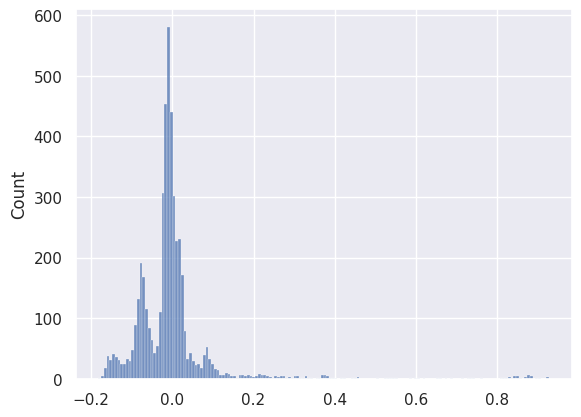

In [155]:
#Check the distribution of error terms
sns.histplot(y_test_2 - RR_model2.predict(X_test_2))

<br>

#### Saving the model

In [156]:
with open('RR_model2.pkl', 'wb') as f:
    pickle.dump(RR_model2, f)

<br>

### Combining the two-stages models
We combine the two models by multiplying the predictions of of the logistic mode (0 or 1) with the predictions of the linear regression model. This way, we maintain all zero predictions from the first model (multiplication by zero) and we maintain the predictions for non-zero values from the second model (through multiplication by one).

As the data is highly skewed, we measure the final predictive performance via Mean Absolute Error (MAE). In this case, it is close to 7 percentage points which is statisfactory given the lack of key predictive variables. We notice also that the distribution of predictions and actual values of the testing data are very similar.

In [157]:
# Combining the predictions from the two models via multiplication of predictions
y_pred_final = pd.Series(RR_model2.predict(X_test_RR) * y_pred_class).astype(float)
y_pred_final.describe().round(2)

count    8572.00
mean        0.09
std         0.07
min         0.00
25%         0.00
50%         0.13
75%         0.15
max         0.21
dtype: float64

In [158]:
# Assessing the final predictive performance via Mean Absolute Error
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(df_final_compare['actual'], df_final_compare['pred'])
MAE

np.float64(0.07855088849350869)

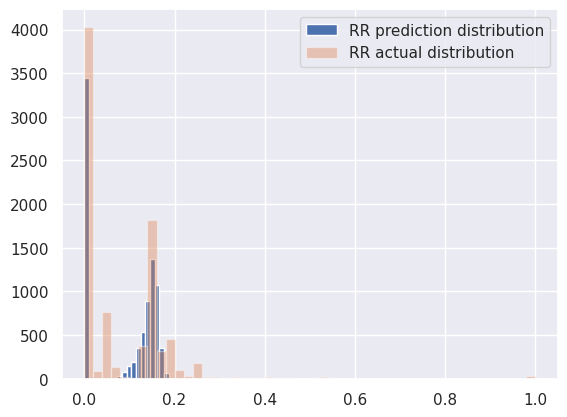

In [159]:
y_pred_final.hist(bins = 20, label = 'RR prediction distribution')
y_test_RR.RR.hist(alpha = 0.4, bins = 50, label = 'RR actual distribution')
plt.legend()

<br>

## EAD Modelling

### Exploring Dependent Varaible EAD

Just like we did for LGD, we now plot a histogram of our EAD to see what distribution can we rely on in modelling.

<Axes: >

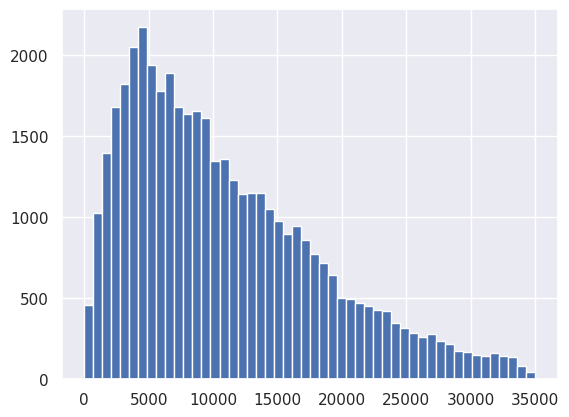

In [160]:
df_defaulted.EAD.hist(bins = 50)

### EAD to Loan Amount Ratio (EADtLA)

Instead of modelling EAD directly, regulators (including BASEL Regulations) often recommend modelling the ratio of **EAD to Total Loan Amount**, i.e. the ratio of amounts unpaid to the original loan amount at the time of default.

This ratio is better for modelling purposes since:
- it is bounded between 0-1. which is unbounded in terms of amounts,
- Portfolio-Level Consistency: This ratio CCF ensures a standardized approach across different credit products and borrower segments.

In [161]:
df_defaulted.loc[:, 'EADtLA'] = (df_defaulted['funded_amnt'] - df_defaulted['total_rec_prncp'])/df_defaulted['funded_amnt']
df_defaulted.EADtLA.describe()

count    42860.000000
mean         0.733635
std          0.200084
min          0.000438
25%          0.629787
50%          0.788084
75%          0.886624
max          1.000000
Name: EADtLA, dtype: float64

<Axes: >

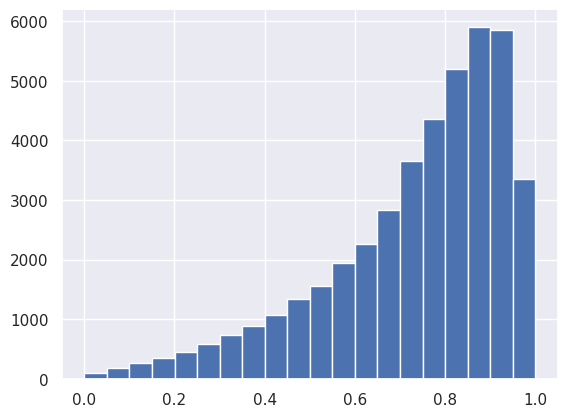

In [162]:
df_defaulted.EADtLA.hist(bins = 20)

We create our training and testing data in a similar manner to the approach followed for LGD data preparation.

In [163]:
df_EADtLA = df_defaulted[['dti','funded_amnt', 'emp_length_int', 'term_int', 'last_payment_months',
                  'mths_since_issue_d', 'mths_since_earliest_cr_line', 'mths_since_last_delinq', 'mths_since_last_record']]
df_EADtLA = pd.concat([df_EADtLA, grade_dummies, home_own_dummies, verif_dummies], axis = 1)
y_EADtLA = df_defaulted['EADtLA']

In [164]:
# Split data into training and test set
X_train_EADtLA, X_test_EADtLA, y_train_EADtLA, y_test_EADtLA = train_test_split(df_EADtLA, y_EADtLA, train_size = 0.8, random_state = 1)


# Adding constants to X_train_RR and X_test_RR
X_train_EADtLA.insert(0, 'intercept', 1)
X_test_EADtLA.insert(0, 'intercept', 1)

print(X_train_EADtLA.shape)
print(X_test_EADtLA.shape)
print(y_train_EADtLA.shape)
print(y_test_EADtLA.shape)

(34288, 22)
(8572, 22)
(34288,)
(8572,)


In [165]:
# Define the Beta regression model using statsmodels
EAD_model = sm.GLM(y_train_EADtLA, X_train_EADtLA.astype(float), family=sm.families.Binomial()).fit()

EAD_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 EADtLA   No. Observations:                34288
Model:                            GLM   Df Residuals:                    34266
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11498.
Date:                Fri, 04 Apr 2025   Deviance:                       705.15
Time:                        02:57:22   Pearson chi2:                     871.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1691
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                          1.8978      0.111     17.053      0.000       1.680       2.116
dti                               -0.0006      0.002     -0.311      0.756      -0.004       0.003
funded_amnt                      7.27e-07   1.99e-06      0.365      0.715   -3.18e-06    4.64e-06
emp_length_int                    -0.0016      0.004     -0.433      0.665      -0.009       0.006
term_int                           0.0443      0.002     27.326      0.000       0.041       0.047
last_payment_months                0.1136      0.002     60.565      0.000       0.110       0.117
mths_since_issue_d                -0.1095      0.002    -63.119      0.000      -0.113      -0.106
mths_since_earliest_cr_line      2.17e-05      0.000      0.131      0.896      -0.000       0.000
mths_since_last_delinq         -7.594e-05      0.001     -0.125      0.900      -0.001       0.001
mths_since_last_record         -1.367e-05      0.000     -0.028      0.978      -0.001       0.001
Grade: _B                          0.0842      0.058      1.463      0.144      -0.029       0.197
Grade: _C                          0.1402      0.057      2.440      0.015       0.028       0.253
Grade: _D                          0.1976      0.060      3.305      0.001       0.080       0.315
Grade: _E                          0.2920      0.069      4.217      0.000       0.156       0.428
Grade: _F                          0.3510      0.086      4.061      0.000       0.182       0.520
Grade: _G                          0.3793      0.136      2.780      0.005       0.112       0.647
Home_Own: _NONE                    0.0766      1.196      0.064      0.949      -2.268       2.421
Home_Own: _OTHER                  -0.0240      0.413     -0.058      0.954      -0.834       0.786
Home_Own: _OWN                     0.0046      0.051      0.091      0.928      -0.095       0.104
Home_Own: _RENT                    0.0084      0.030      0.280      0.779      -0.050       0.067
Verif_Status: _Source Verified     0.0205      0.037      0.548      0.583      -0.053       0.094
Verif_Status: _Verified            0.0227      0.036      0.640      0.522      -0.047       0.092
==================================================================================================
"""

<br>

### Prediction performance of EAD_to_Loan ratio

The correlation between the predictions and actual EAD_to_Loan ratio is very high at 0.96 with both vectors having very similar distribution.

In [166]:
EAD_comp = pd.DataFrame({'pred': EAD_model.predict(X_test_EADtLA.astype(float)), 'actual': y_test_EADtLA})
EAD_comp.corr()

,pred,actual
pred,1.000000,0.959084
actual,0.959084,1.000000


Text(0.5, 1.0, 'Distribution of EAD to Loan_Amount Ratio')

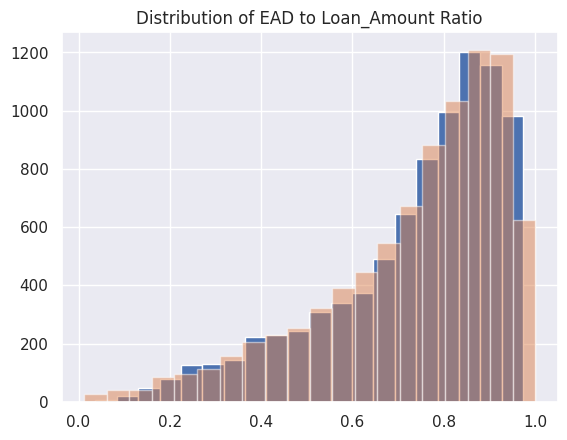

In [167]:
EAD_comp.pred.hist(bins = 20, label = 'Predictions Distribution')
EAD_comp.actual.hist(bins = 20, alpha = 0.5, label = 'Actual Distribution')
plt.title('Distribution of EAD to Loan_Amount Ratio')

<br>

### Saving the model

In [168]:
with open('EAD_model.pkl', 'wb') as f:
    pickle.dump(EAD_model, f)